In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [3]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)
print("Shape of dataset is:",(df.count(),len(df.columns)))

Shape of dataset is: (150, 5)


In [4]:
df.show(10)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|         5.0|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 10 rows



In [5]:
df.columns


['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [6]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [7]:
df.select('species').distinct().count()

3

In [8]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|setosa    |50   |
|versicolor|50   |
|virginica |50   |
+----------+-----+



In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [13]:
errors=[]

for k in range(2,15):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 152.36870647734008
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 78.94506582597637
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 57.34540931571787
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 49.95165000000074
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 42.18842883597854
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 40.99846908831891
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 36.41886904761948
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 34.742213908172545
------------------------------------------------------------
With K=10
With

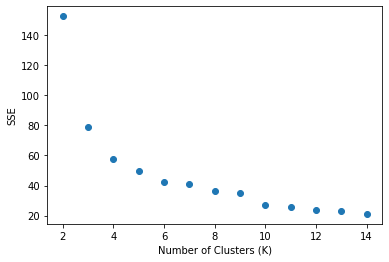

In [14]:
cluster_number = range(2,15)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [15]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)

In [16]:
model = kmeans.fit(final_data)

In [17]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         2|   50|
|         0|   61|
+----------+-----+



In [18]:
predictions=model.transform(final_data)

In [19]:
predictions.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [20]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
|    setosa|         2|   50|
| virginica|         0|   14|
| virginica|         1|   36|
|versicolor|         1|    3|
|versicolor|         0|   47|
+----------+----------+-----+



In [21]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
65,6.7,3.1,4.4,1.4,versicolor,"[6.7, 3.1, 4.4, 1.4]",0
36,5.5,3.5,1.3,0.2,setosa,"[5.5, 3.5, 1.3, 0.2]",2
122,7.7,2.8,6.7,2.0,virginica,"[7.7, 2.8, 6.7, 2.0]",1
32,5.2,4.1,1.5,0.1,setosa,"[5.2, 4.1, 1.5, 0.1]",2
67,5.8,2.7,4.1,1.0,versicolor,"[5.8, 2.7, 4.1, 1.0]",0


In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

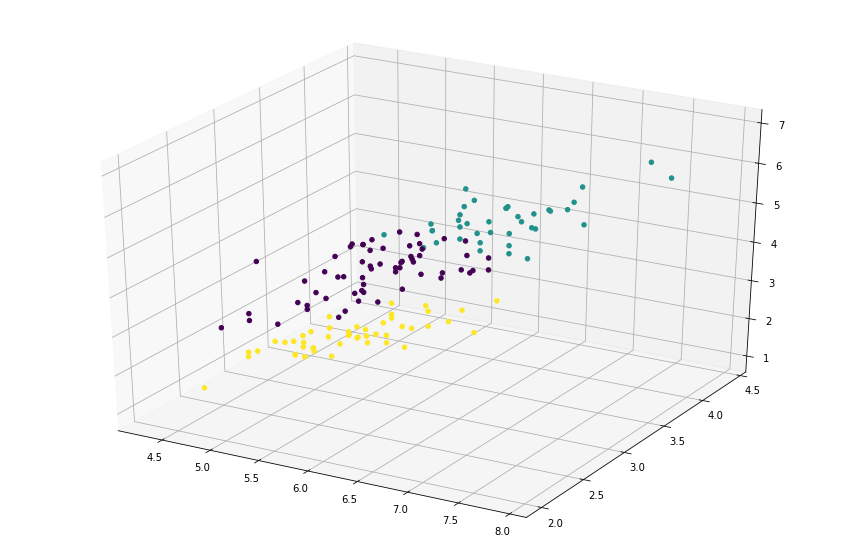

In [24]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()